# Description of the final project

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:

### [25%] 1. Data exploration

* 1.1. (8%) Which metric are you going to use to evaluate the performance of the model and why?
* 1.2. (8%) Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step
* 1.3. (9%) Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions

### [25%] 2. Data preprocessing

* 2.1. (8%) Fill missing values (if there are any)
* 2.2. (9%) Properly encode categorical features. Explain your choice of methods of categorical feature encoding
* 2.3. (8%) Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality

### [25%] 3. Model training

* 3.1. (8%) Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)
* 3.2. (9%) Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models
* 3.3. (8%) Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble

### [25%] 4. Summary

* 4.1. (8%) Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?
* 4.2. (8%) Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)
* 4.3. (9%) Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import set_style
from sklearn.preprocessing import OneHotEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler, TomekLinks
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTE
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

set_style("darkgrid")
%matplotlib inline

In [2]:
columns = []
with open('census-income.names') as f:
    while True:
        line = f.readline()
        if len(line) > 0 and line[0] == '|':
            continue
        values = line.split(':')
        if len(values) == 2:
            columns.append(values[0])
        if not line: 
            break

In [3]:
columns.append('target')

In [4]:
data = pd.read_csv('census-income.data', names=columns, header=None) 

In [5]:
data.shape

(199523, 42)

In [6]:
test = pd.read_csv('census-income.test', names=columns, header=None) 

In [7]:
test.shape

(99762, 42)



# 1.1 Select Metric
This is imbalanced dataset. We have only 6% of data with income above 50K

I will use balanced accuracy score to account for True Negatives

In [8]:
data['target'].value_counts()

 - 50000.    187141
 50000+.      12382
Name: target, dtype: int64

In [9]:
data['target'].value_counts()[1]*100/data.shape[0]  # above 50K 6.2% in train data

6.205800834991455

In [10]:
data['target_b'] = np.where(data['target'] == ' - 50000.', 0, 1)  #create binary target variable

In [11]:
test['target_b'] = np.where(test['target'] == ' - 50000.', 0, 1)

In [12]:
data['target_b'].value_counts()

0    187141
1     12382
Name: target_b, dtype: int64

# 1.2 Select Validation Strategy

I will use K-fold for validation. This is important for imbalanced datasets.

# 1.3 Feature Selection

In [13]:
# split columns based on data type

num_col = ['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour', 'capital gains', 
             'capital losses', 'dividends from stocks', 'num persons worked for employer', 'own business or self employed',
            'veterans benefits', 'weeks worked in year', 'year']

cat_nominal = ['class of worker', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code',
              'race', 'hispanic origin', 'member of a labor union', 'reason for unemployment',
              'full or part time employment stat', 'tax filer stat', 'region of previous residence', 
               'state of previous residence', 'detailed household and family stat', 'detailed household summary in household',
              'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg',
              'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18',
              'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship',
              'fill inc questionnaire for veteran\'s admin']

cat_binary = ['sex']

cat_ordered = ['education']

ignore = ['instance weight']

target_col = ['target', 'target_b']

In [14]:
len(data.columns) == len(num_col) + len(cat_nominal) + len(cat_binary) + len(cat_ordered) + len(ignore) + len(target_col)

True

<b> Check numeric columns

In [15]:
# get all numerical columns + target_b

data_num = data[['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour', 'capital gains', 
             'capital losses', 'dividends from stocks', 'num persons worked for employer', 'own business or self employed',
            'veterans benefits', 'weeks worked in year','year', 'target_b']]

In [16]:
data_num.describe() # money columns have high deviation

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year,target_b
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1.956180,0.175438,1.514833,23.174897,94.499672,0.062058
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,2.365126,0.553694,0.851473,24.411488,0.500001,0.241261
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000,0.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000,0.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,2.000000,8.000000,94.000000,0.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,2.000000,52.000000,95.000000,0.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000,1.000000


<AxesSubplot:>

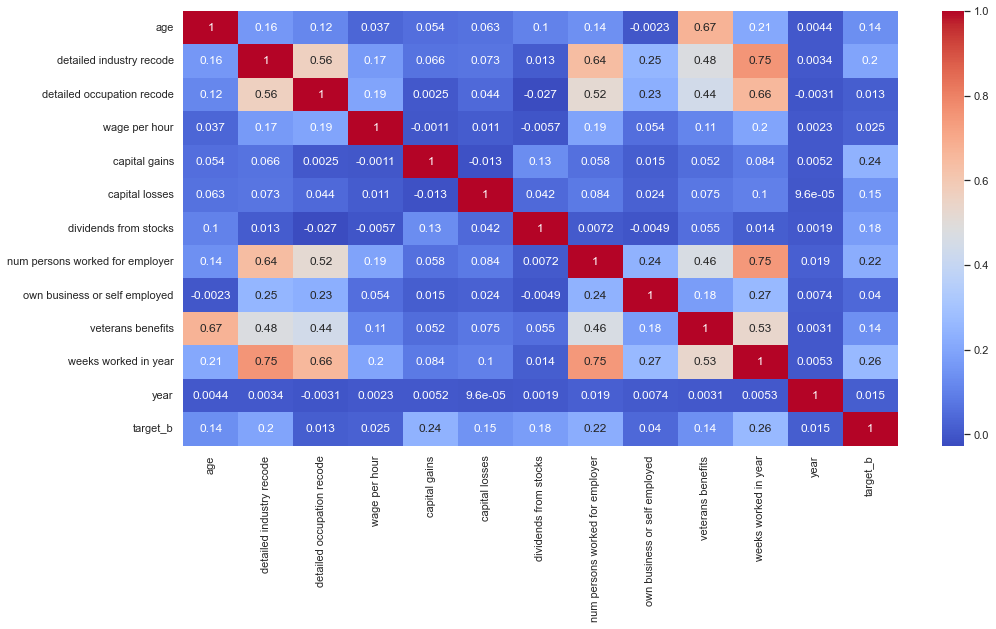

In [17]:
# none of the numberic columns have high (> 0.5) correlation with target

sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(data_num.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

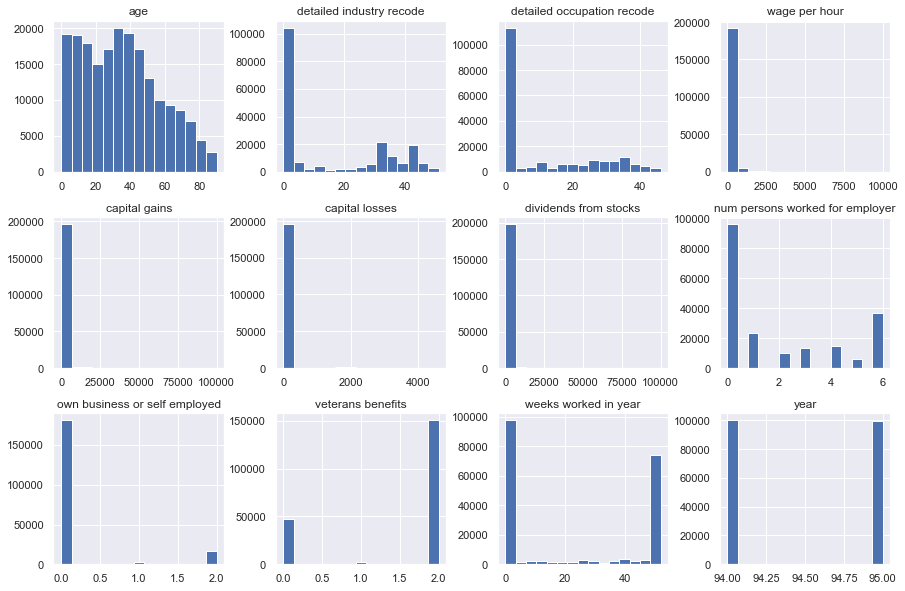

In [18]:
data_num[num_col].hist(bins=15, figsize=(15, 10), layout=(3, 4));


# 2.1 Check for missing values

In [19]:
data.isna().sum()  # no missing values

age                                           0
class of worker                               0
detailed industry recode                      0
detailed occupation recode                    0
education                                     0
wage per hour                                 0
enroll in edu inst last wk                    0
marital stat                                  0
major industry code                           0
major occupation code                         0
race                                          0
hispanic origin                               0
sex                                           0
member of a labor union                       0
reason for unemployment                       0
full or part time employment stat             0
capital gains                                 0
capital losses                                0
dividends from stocks                         0
tax filer stat                                0
region of previous residence            

<b> Check categorical columns

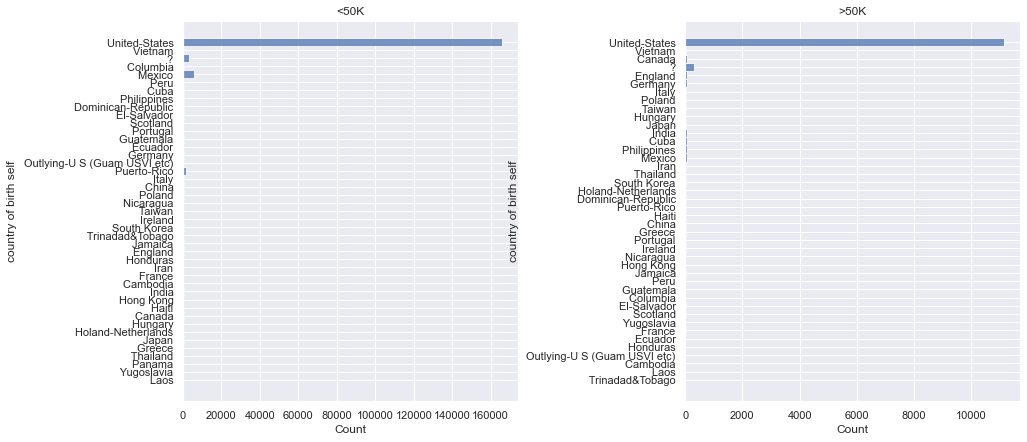

In [20]:
# check columns that have little usefull data to see if they have dependency on target

h_data_0 = data[data.target_b==0]
h_data_1 = data[data.target_b==1]

sns.set(rc = {'figure.figsize':(15,7)})

fig, ax =plt.subplots(1,2)
sns.histplot(data=h_data_0, y='country of birth self', ax=ax[0]).set(title='<50K')
sns.histplot(data=h_data_1, y='country of birth self', ax=ax[1]).set(title='>50K')
fig.subplots_adjust(wspace=0.5)


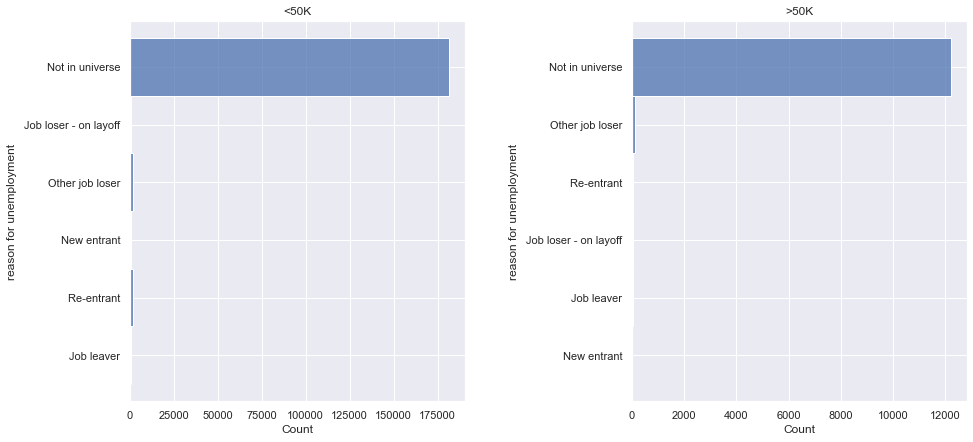

In [21]:
sns.set(rc = {'figure.figsize':(15,7)})

fig, ax =plt.subplots(1,2)
sns.histplot(data=h_data_0, y='reason for unemployment', ax=ax[0]).set(title='<50K')
sns.histplot(data=h_data_1, y='reason for unemployment', ax=ax[1]).set(title='>50K')
fig.subplots_adjust(wspace=0.5)

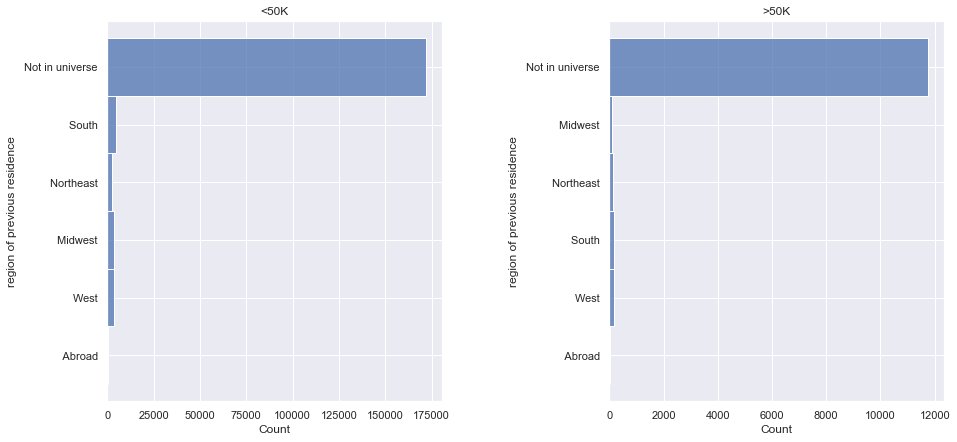

In [22]:
sns.set(rc = {'figure.figsize':(15,7)})

fig, ax =plt.subplots(1,2)
sns.histplot(data=h_data_0, y='region of previous residence', ax=ax[0]).set(title='<50K')
sns.histplot(data=h_data_1, y='region of previous residence', ax=ax[1]).set(title='>50K')
fig.subplots_adjust(wspace=0.5)

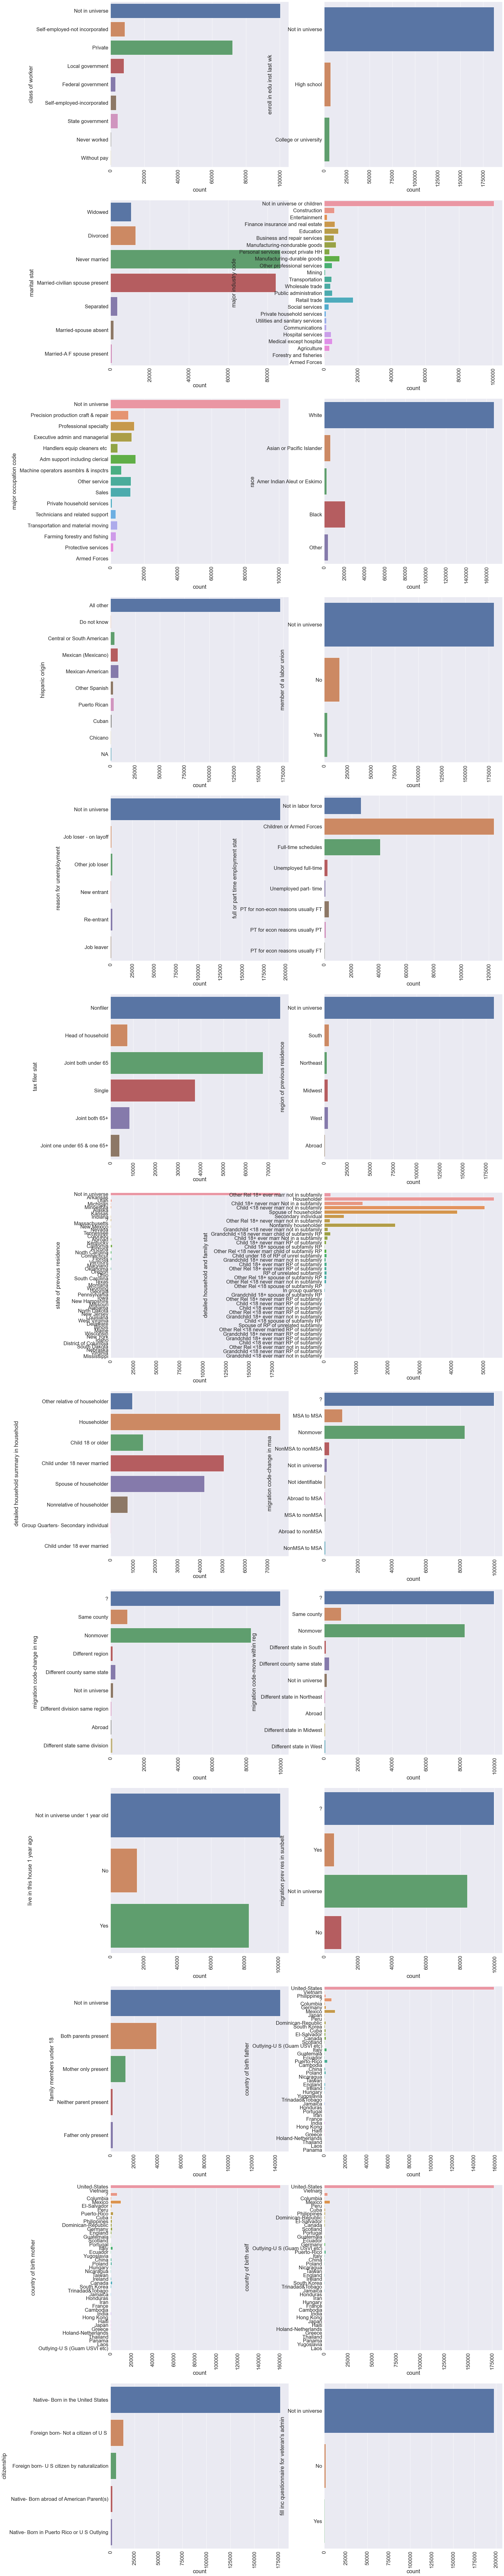

In [23]:
#check all categorical columns for values distribution

sns.set(font_scale=2)

fig, ax = plt.subplots(13, 2, figsize=(30, 200))
for variable, subplot in zip(cat_nominal, ax.flatten()):
    sns.countplot(y=data[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        
fig.subplots_adjust(wspace=0.2)

In [24]:
# these columns contain identical info

In [25]:
data.loc[data['detailed occupation recode'] ==43]['major occupation code'].value_counts()

 Farming forestry and fishing    1382
Name: major occupation code, dtype: int64

In [26]:
data.loc[data['detailed industry recode'] ==37]['major industry code'].value_counts()

 Business and repair services    4022
Name: major industry code, dtype: int64

In [27]:
# assign encoding to categorical columns
# small number of features -> ohe
# large number of features -> target
# drop columns with little info

cat_ohe = ['enroll in edu inst last wk', 'race', 'member of a labor union', 
           'live in this house 1 year ago', 'migration prev res in sunbelt',
          'family members under 18', 'citizenship', 'fill inc questionnaire for veteran\'s admin']

cat_target = ['class of worker', 'marital stat', 'major industry code', 'major occupation code',
             'full or part time employment stat', 'tax filer stat', 'detailed household and family stat', 
              'detailed household summary in household', 'migration code-change in msa',
             'migration code-change in reg', 'migration code-move within reg']

cat_drop = ['hispanic origin', 'reason for unemployment', 'region of previous residence',
           'state of previous residence', 'country of birth father',
           'country of birth mother', 'country of birth self']

In [28]:
len(cat_nominal) == len(cat_ohe) + len(cat_target) + len(cat_drop)

True

In [29]:
def feature_processing(df):
    
    # drop correalted columns, ingnore column and non binary target column
    df1 = df.drop(columns=['detailed occupation recode', 'detailed industry recode', 'instance weight', 'target'])
    
    # drop cat columns with little info
    df1 = df1.drop(columns=cat_drop)
    
    # combine money columns into one
    df1['gains'] = df1['capital gains'] - df1['capital losses'] + df1['dividends from stocks']
    df1.drop(columns=['capital gains', 'capital losses', 'dividends from stocks'], inplace=True)
    
    # process binary column
    sex_map = {' Female': 0, ' Male': 1}
    df1['sex'] = df1['sex'].map(sex_map, na_action='ignore')
    
    # process ordinal column
    edu_map = {
        ' Children' : 0, 
        ' Less than 1st grade' : 1,
        ' 1st 2nd 3rd or 4th grade' : 2,
        ' 5th or 6th grade' : 3,
        ' 7th and 8th grade' : 4,
        ' 9th grade' : 5,
        ' 10th grade' : 6,
        ' 11th grade' : 7,
        ' 12th grade no diploma' : 8,
        ' High school graduate' : 9,
        ' Associates degree-academic program' : 10,
        ' Associates degree-occup /vocational' : 10,
        ' Prof school degree (MD DDS DVM LLB JD)' : 11,
        ' Some college but no degree' : 11,
        ' Bachelors degree(BA AB BS)' : 12,
        ' Masters degree(MA MS MEng MEd MSW MBA)' : 13,
        ' Doctorate degree(PhD EdD)' : 14
    }
       
    df1['education'] = df1['education'].map(edu_map, na_action='ignore')
    
    return df1

In [30]:
# process features

train = feature_processing(data)
test = feature_processing(test)

In [31]:
len(train.columns) == len(test.columns)

True

In [32]:
col_proc = ['age', 'wage per hour', 'gains', 'num persons worked for employer', 'own business or self employed',
            'veterans benefits', 'weeks worked in year', 'year', 'sex', 'education']

In [33]:
len(train.columns) == len(col_proc) + len(cat_ohe) + len(cat_target) + 1 # +1 for target

True

In [34]:
# define encoders for cat columns

def one_hot_encoder(train, test, cols_encode, target=None):
    """ one hot encoding"""
    ohc_enc = OneHotEncoder(handle_unknown='ignore')
    ohc_enc.fit(train[cols_encode])
    train_ohc = ohc_enc.transform(train[cols_encode])
    test_ohc = ohc_enc.transform(test[cols_encode])
    
    column_name = ohc_enc.get_feature_names(cols_encode)
    train_ohc =  pd.DataFrame(train_ohc.toarray(), columns= column_name)
    test_ohc =  pd.DataFrame(test_ohc.toarray(), columns= column_name)
    
    return train_ohc, test_ohc

In [35]:
# define encoders for cat columns

def cat_boost_encoder(train, test, cols_encode, target):
    """ one hot encoding"""
    
    cb = CatBoostEncoder(handle_missing='return_nan')
    cb.fit(train[cols_encode], target)
    
    train_ohc = cb.transform(train[cols_encode])
    test_ohc = cb.transform(test[cols_encode])
    
    return train_ohc, test_ohc

In [36]:
def kfold_target_encoder(train, test, cols_encode, target, folds=10):
    """
    Mean regularized target encoding based on kfold
    """
    train_new = train.copy()
    test_new = test.copy()
    kf = KFold(n_splits=folds)
    for col in cols_encode:
        global_mean = train_new[target].mean()
        for train_index, test_index in kf.split(train):
            mean_target = train_new.iloc[train_index].groupby(col)[target].mean()
            train_new.loc[test_index, col + "_mean_enc"] = train_new.loc[test_index, col].map(mean_target)
        train_new[col + "_mean_enc"].fillna(global_mean, inplace=True)
        # making test encoding using full training data
        col_mean = train_new.groupby(col)[target].mean()
        test_new[col + "_mean_enc"] = test_new[col].map(col_mean)
        test_new[col + "_mean_enc"].fillna(global_mean, inplace=True)
    
    # filtering only mean enc cols
    train_new = train_new.filter(like="mean_enc", axis=1)
    test_new = test_new.filter(like="mean_enc", axis=1)
    return train_new, test_new

In [37]:
X = train[col_proc]
train_ohe, _ = one_hot_encoder(train, test, cat_ohe)
train_tg, _ = kfold_target_encoder(train, test, cat_target, 'target_b')
X = X.join(train_ohe)
X = X.join(train_tg)

y = train['target_b']

selected important features after training models -- see below

In [38]:
important_col = ['major occupation code_mean_enc', 'education', 'major industry code_mean_enc', 
                 'age', 'gains', 'weeks worked in year']

In [39]:
X_imp = X[important_col]

In [40]:
dbscan = DBSCAN(eps=0.5, min_samples=2000)
clusters = dbscan.fit_predict(X_imp)

In [41]:
set(clusters)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [42]:
X['cluster']=pd.Series(clusters)

In [43]:
X['cluster'].value_counts()

-1     152101
 10      3332
 7       3318
 13      3279
 5       3236
 9       3218
 2       3187
 11      3171
 0       3162
 3       3152
 6       3138
 1       3134
 8       3128
 14      3068
 4       3060
 12      2839
Name: cluster, dtype: int64

# 3. Model training

In [44]:
def compute_metrics(y_test, y_pred):
    print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))

def compute_confusion_matrix(y_test, y_pred):
    compute_metrics(y_test, y_pred)
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=[1, 0]),
        columns=['a(x) = 1', 'a(x) = 0'],
        index=['y = 1', 'y = 0'],
    ).T

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=12)

In [46]:
RF_clf = RandomForestClassifier(n_estimators=150, random_state=12, class_weight='balanced')

XGB_clf = XGBRegressor(objective='binary:logistic', eval_metric='error', n_estimators=200, 
                       learning_rate=0.04, max_depth=5, random_state=12)

LGBM_clf = LGBMRegressor(objective='binary', n_estimators=250,
                          learning_rate=0.03, max_depth=5, random_state=12)

In [47]:
rus = RandomUnderSampler(random_state=12)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

RF_clf.fit(X_resampled, y_resampled)
y_pred = RF_clf.predict(X_val)
compute_confusion_matrix(y_val, y_pred)

Accuracy (balanced): 0.86796


,y = 1,y = 0
a(x) = 1,2693,7456
a(x) = 0,316,39416


In [48]:
XGB_clf.fit(X_resampled, y_resampled)
y_pred = XGB_clf.predict(X_val)
y_pred = np.where(y_pred > 0.5, 1, 0)
compute_confusion_matrix(y_val, y_pred)

Accuracy (balanced): 0.87761


,y = 1,y = 0
a(x) = 1,2736,7221
a(x) = 0,273,39651


In [49]:
LGBM_clf.fit(X_resampled, y_resampled)
y_pred = LGBM_clf.predict(X_val)
y_pred = np.where(y_pred > 0.5, 1, 0)
compute_confusion_matrix(y_val, y_pred)

Accuracy (balanced): 0.87706


,y = 1,y = 0
a(x) = 1,2733,7226
a(x) = 0,276,39646


# Checking important features and possible clustering

In [50]:
feature_importances = zip(X_train.columns, RF_clf.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

In [51]:
feature_importances.head(10)

,feature,importance
0,major occupation code_mean_enc,0.129484
1,education,0.097958
2,age,0.089316
3,gains,0.085458
4,weeks worked in year,0.078961
5,major industry code_mean_enc,0.067831
6,num persons worked for employer,0.057174
7,class of worker_mean_enc,0.056350
8,tax filer stat_mean_enc,0.044264
9,detailed household and family stat_mean_enc,0.042557


In [52]:
feature_importances = zip(X_train.columns, XGB_clf.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

In [53]:
feature_importances.head(10)

,feature,importance
0,major occupation code_mean_enc,0.346756
1,weeks worked in year,0.130001
2,education,0.068311
3,sex,0.064840
4,gains,0.056379
5,tax filer stat_mean_enc,0.041126
6,age,0.037924
7,detailed household and family stat_mean_enc,0.034020
8,num persons worked for employer,0.020613
9,major industry code_mean_enc,0.016133


In [54]:
feature_importances = zip(X_train.columns, LGBM_clf.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

In [55]:
feature_importances.head(10)

,feature,importance
0,gains,979
1,age,675
2,education,482
3,class of worker_mean_enc,446
4,major industry code_mean_enc,391
5,major occupation code_mean_enc,388
6,weeks worked in year,376
7,detailed household and family stat_mean_enc,277
8,sex,276
9,tax filer stat_mean_enc,253


In [56]:
important_col = ['major occupation code_mean_enc', 'education', 'major industry code_mean_enc', 
                 'age', 'gains', 'weeks worked in year']

In [57]:
X_imp = X_train[important_col]

In [58]:
k_means = KMeans(n_clusters=2, random_state=12)
clusters = k_means.fit_predict(X_train)

In [59]:
compute_confusion_matrix(y_train, clusters)

Accuracy (balanced): 0.51503


,y = 1,y = 0
a(x) = 1,284,34
a(x) = 0,9089,140235


In [60]:
pca = PCA(n_components=2, random_state=12)
pc_out = pca.fit_transform(X_train)

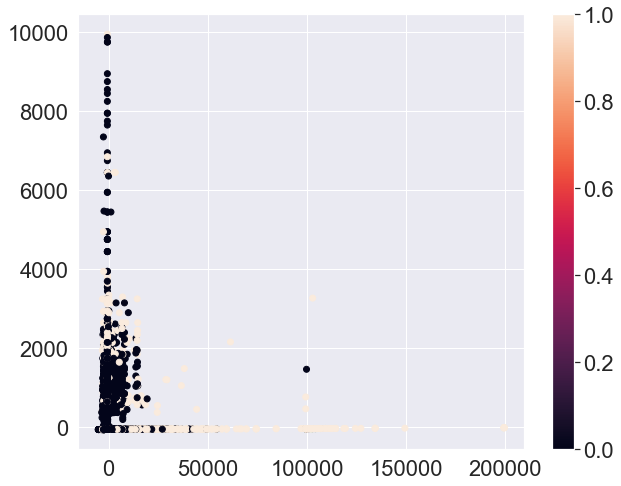

In [61]:
plt.figure(figsize=(10, 8))
plt.scatter(pc_out[:, 0], pc_out[:, 1], c=y_train)
plt.colorbar()
plt.show()

In [62]:
dbscan = DBSCAN(eps=0.7, min_samples=1000)
clusters = dbscan.fit_predict(X_imp)
len(clusters)

149642

In [63]:
set(clusters)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

# Ensemble

These models are highly correlated so ensemble does not work

In [64]:
xgb = pd.DataFrame(XGB_clf.predict(X_val), columns=['xgb'])
lgb = pd.DataFrame(LGBM_clf.predict(X_val), columns=['lgb'])
rf = pd.DataFrame(RF_clf.predict(X_val), columns=['rf'])
X_val_blend = pd.concat([xgb, lgb, rf], axis=1)

In [65]:
X_val_blend.corr()

,xgb,lgb,rf
xgb,1.000000,0.998583,0.866675
lgb,0.998583,1.000000,0.865483
rf,0.866675,0.865483,1.000000


In [67]:
w_range = np.linspace(0, 1, 101)
result_row = []
results = []

for w1 in tqdm(w_range):
    for w2 in w_range:
        for w3 in w_range:
                
                if w1 + w2 + w3 == 1.0:

                    result_row.append([w1, w2, w3])
                    
                    pred = w1*X_val_blend['xgb'] + w2*X_val_blend['lgb'] + w3*X_val_blend['rf']

                    bac = balanced_accuracy_score(y_val, np.where(pred > 0.5, 1, 0))
                    result_row.append(bac)
                    results.append(result_row)
                result_row =[]

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:48<00:00,  1.07s/it]


In [68]:
sorted(results, key=lambda x: x[1])[0]

[[0.0, 0.0, 1.0], 0.8679551037959683]

# Test data results

We can use any of these models for predictions
They all have the same quality

In [69]:
X_test = test[col_proc]
_, test_ohe = one_hot_encoder(train, test, cat_ohe)
_, test_tg = kfold_target_encoder(train, test, cat_target, 'target_b')
X_test = X_test.join(test_ohe)
X_test = X_test.join(test_tg)

y_test = test['target_b']

In [73]:
X_imp = X_test[important_col]
dbscan = DBSCAN(eps=0.5, min_samples=2000)
clusters = dbscan.fit_predict(X_imp)

In [74]:
X_test['cluster']=pd.Series(clusters)

In [75]:
y_pred = RF_clf.predict(X_test)
compute_confusion_matrix(y_test, y_pred)

Accuracy (balanced): 0.87302


,y = 1,y = 0
a(x) = 1,5546,14083
a(x) = 0,640,79493


In [76]:
y_pred = XGB_clf.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
compute_confusion_matrix(y_test, y_pred)

Accuracy (balanced): 0.87549


,y = 1,y = 0
a(x) = 1,5577,14089
a(x) = 0,609,79487


In [77]:
y_pred = LGBM_clf.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
compute_confusion_matrix(y_test, y_pred)

Accuracy (balanced): 0.87584


,y = 1,y = 0
a(x) = 1,5581,14085
a(x) = 0,605,79491


# Summary

Adding a new feature based on clustering did not impove perfomance of the models.


Based on important features all 3 models are selecting almost the same features and are highly correlated therefore putting them into an ensamble did not improve results.

The biggest improvement was achieved through under sampling. Tried over sampling -did not work as well as under sampling.

Models where tested on validataion data set therefore provide stable performance on test data